# [E-08]Pneumonia Diagnosis ( 폐렴 진단 )
_____

## 목차
### 1. 개요
    1.1 들어가기에 앞서
    1.2 루브릭 평가기준
### 2. 프로젝트: 폐렴 진단기 성능개선
    2.1 실습환경 Set-up
    2.2 데이터 준비하기
    2.3 데이터 시각화
    2.4 CNN 모델링
    2.5 데이터 imbalance 처리
    2.6 모델 훈련
    2.7 결과 확인과 시각화
### 3. 결론
    3.1 결론
    3.2 참조
    3.3 회고

-----

## 1. 개요
### 1.1 들어가기에 앞서

의료 영상 분석은 일반적인 이미지와 다르게 다음과 같은 특징이 있다.

- 의료 영상 이미지는 개인 정보 보호 등의 이슈로 인해 **데이터를 구하는 것이 쉽지 않다.**

- 라벨링 작업 자체가 전문적 지식을 요하므로 **데이터셋 구축 비용이 비싸다.**

- 데이터를 입수할 때 **희귀질병의 데이터는 구하기 어렵다.**

- **음성/양성 데이터 간 imbalance가 심하여** 학습에 주의가 필요하다.

- 이미지만으로 진단이 쉽지 않아 **다른 데이터와 결합해서 해석해야 할 수도 있다.**

그렇기 때문에 영상 처리를 위해 **딥러닝 영상처리 기술, 의료 도메인 지식 및 의료 영상에 대한 이해**가 필요하다


---

#### 의료영상 자세 분류

![1](https://d3s0tskafalll9.cloudfront.net/media/images/06.max-800x600.png)

X-RAY 이미지를 이해하기 위해, 위 사진과 같이 자세 분류 체계를 이해해야 한다.

- Sagittal plane(시상면): 사람을 왼쪽과 오른쪽을 나누는 면
- Coronal plane(관상면): 인체를 앞뒤로 나누는 면
- Transverse plane(횡단면=수평면): 인체를 상하로 나누는 면

---

#### X-RAY 명암

- 뼈: 하얀색
- 근육 및 지방: 연한 회색
- 공기나 폐: 검정색 

---

#### 폐렴 구별법

- X-RAY 사진 상으로, 폐 부위에 희미한 그림자 증가를 통해 관찰 가능
![2](https://d3s0tskafalll9.cloudfront.net/media/original_images/12_e0QcAmT.png)

- X-RAY(왼쪽) 이미지: 그림자가 없는 깨끗한 폐
- X-RAY(중간) 이미지: 세균성 폐렴이 화살표가 있는 쪽에 나타남
- X-RAY(오른쪽) 이미지: 바이러스성 폐렴이 고루고루 퍼져 나타남

---


### 1.2 루브릭 평가기준
평가문항|상세기준
-|-
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.

---


## 2. 프로젝트: 폐렴 진단기 성능개선
### 2.1 실습환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

- 필요한 패키지, 모듈 불러오기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 30
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


- 앞으로 필요할 변수 생성
- BATCH_SIZE = 32, EPOCHS = 30

---

### 2.2 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('train 데이터의 개수:', len(train_filenames))
print('test 데이터의 개수:', len(test_filenames))
print('val 데이터의 개수:', len(val_filenames))

train 데이터의 개수: 5216
test 데이터의 개수: 624
val 데이터의 개수: 16


- 각각의 데이터 개수 출력후 개수 비율 확인
- 개수 비율은 89 : 10.7 : 0.3

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('train 데이터의 개수:', len(train_filenames))
print('val 데이터의 개수:', len(val_filenames))

train 데이터의 개수: 4185
val 데이터의 개수: 1047


- 각각의 데이터 분포를 고려해야 하므로, 비율을 맞추어야 함
- tain:val 비율을 8:2로 나눔

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


- train 데이터 안에 이미지 개수 확인을 위해 파일 경로 확인

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- training set 안의 정상 이미지와 폐렴 이미지 개수 확인

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- tf.data 인스턴스 생성
- tf.data는 텐서플로우에서 학습시킬 때, 미니배치로 작업할 수 있도록 함
- 미니배치를 사용하는 이유는 배치 사이즈를 줄여 연산 시간을 단축시키기 위해

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- Train 데이터셋, val 데이터셋 개수 재차 확인

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 기존 이미지에는 라벨 데이터가 없었음
- 파일 경로에 'NORMAL','PNEUMONIA'가 포함되어 있기 때문에 라벨 데이터를 만들어 주는 함수 생성

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- decode_img 함수로 이미지 사이즈를 통일
- process_path 함수로 라벨을 검출하고 이미지를 읽고 알맞는 형식으로 통일

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- train 데이터 셋과 validation 데이터 셋 생성
- num_parallel_calls 파라미터 위에서 할당한 AUTOTUNE 변수를 이용하여 더욱 빠르게 데이터를 처리

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- 하나의 데이터를 끌어와 이미지 리사이즈 변환 확인, 라벨이 잘 들어가 있는지 확인

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- test 데이터셋 생성 및 데이터 개수 확인

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- augmentation 기법을 추가로 사용하여 랜덤하게 좌우 반전
- prepare_for_training() 함수로 데이터를 변환
- shuffle(): 고정 크기 버퍼 유지후 무작위로 균일하게 다음 요소 선택
- repeat(): 자동으로 데이터를 맞춰줌
- batch(): 배치사이즈에서 정한 만큼의 배치로 주어짐
- prefetch(): 학습데이터를 나누어서 읽어옴
- 문제점: X-RAY같은 의료 영상의 특성산 육안으로 구분하기 어려운 미묘한 차이에 더해진 노이즈 효과가 시각적으로 방해줄 수 있기 때문에 augmentation 도입은 신중해야 한다

---

### 2.3 데이터 시각화

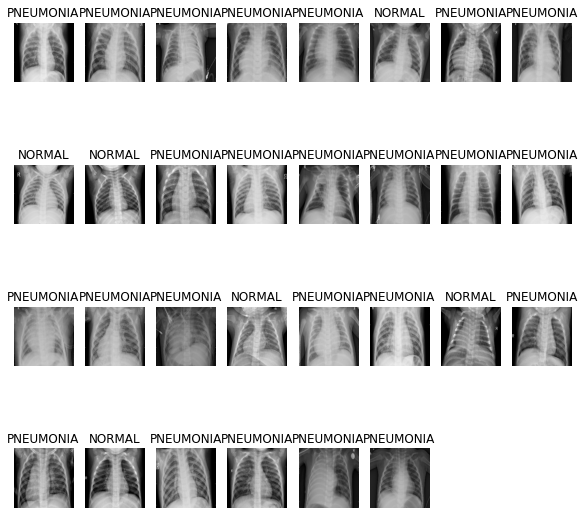

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

- train 데이터에 있는 batch 중에서 첫 번째 배치 추출
- 추출된 배치를 image와 label 데이터 셋으로 나눈 후 show_batch()함수로 사진 출력

---

### 2.4 CNN 모델링




In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- conv_block 생성 후 레이어 구성은 conv를 2번 진행후 Batch Normalization을 통해 Gradient vanishing, Gradient Exploding의 문제점을 해결. 그리고 나서 MaxPooling을 함

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- dense_block 생성
- BatchNormalization과 Dropout 사용

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.1),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

- 모델 구성

---

### 2.5 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


- Pneumonia 데이터가 많기 때문에 학습효과가 좋지 않을 수 있으므로, Weight balancing이라는 테크닉 사용
- 'weight_for_0'은 'NORMAL' 이미지에 사용할 weight 세팅
- 'weight_for_1'은 'PNEUUMONIA' 이미지에 사용할 weight 세팅
- 'NORMAL'과 'PNEUUMONIA' 전체 데이터 건수에 반비례하도록 설정

---

### 2.6 모델 훈련


In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- 이미지 훈련을 위해 GPU를 선택
- 이미지 라벨이 2가지 밖에 없기 때문에 binary_cross entropy를 loss로 사용
- 'accuracy', 'precision', 'recall'로 모델의 성능 확인

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
139/139 [==============================] - 61s 342ms/step - loss: 0.3820 - accuracy: 0.8094 - precision: 0.9579 - recall: 0.7778 - val_loss: 0.5902 - val_accuracy: 0.7333 - val_precision: 0.7333 - val_recall: 1.0000
Epoch 2/30
139/139 [==============================] - 48s 346ms/step - loss: 0.2078 - accuracy: 0.9161 - precision: 0.9755 - recall: 0.9101 - val_loss: 0.8162 - val_accuracy: 0.7343 - val_precision: 0.7343 - val_recall: 1.0000
Epoch 3/30
139/139 [==============================] - 49s 353ms/step - loss: 0.1924 - accuracy: 0.9309 - precision: 0.9782 - recall: 0.9278 - val_loss: 1.0540 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/30
139/139 [==============================] - 49s 357ms/step - loss: 0.1540 - accuracy: 0.9436 - precision: 0.9828 - recall: 0.9406 - val_loss: 1.4084 - val_accuracy: 0.7343 - val_precision: 0.7343 - val_recall: 1.0000
Epoch 5/30
139/139 [==============================] - 53s 384ms/step - loss: 0.1569 - accura

- 모델 학습

---

### 2.7 결과 확인과 시각화


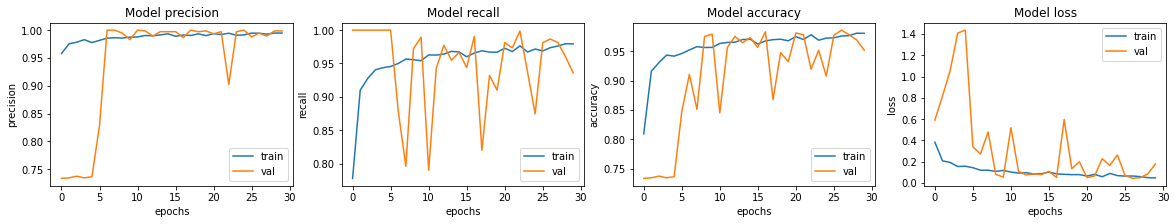

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- 훈련 모델 시각화

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

21/21 [==============================] - 4s 200ms/step - loss: 0.6737 - accuracy: 0.8478 - precision: 0.8256 - recall: 0.9590
Loss: 0.673706591129303,
Accuracy: 0.8477563858032227,
Precision: 0.8256070613861084,
Recall: 0.9589743614196777


- 최종 Loss, Accuracy, Precision, Recall 출력

---

## 3. 결론

### 3.1 결론

# 1차 시도

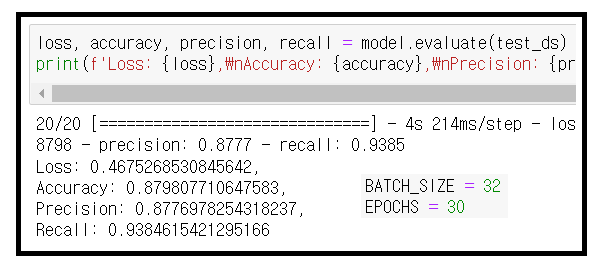

- 1차 시도 정확도 : 87%
- 첫 시도에는 배치사이즈 32, 에포크 30을 두고 BatchNormalization과 Dropout을 변경하지 않고 진행하여 비교적 높은 정확도를 보였다.

# 2차 시도

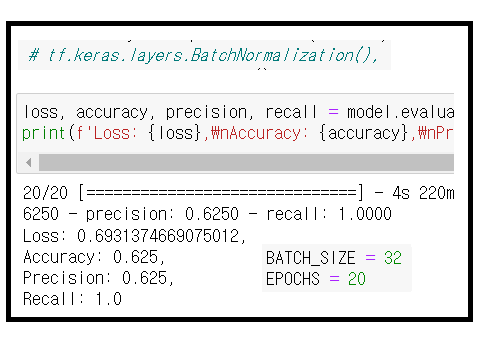

- 2차 시도 정확도: 62%
- 앞서 시도와는 다르게 BatchNormalization 없이 모델학습을 진행했고, 에포크를 20으로 낮추었으나 정확도가 기대한 것보다 낮게 측정됐다.

# 3차 시도

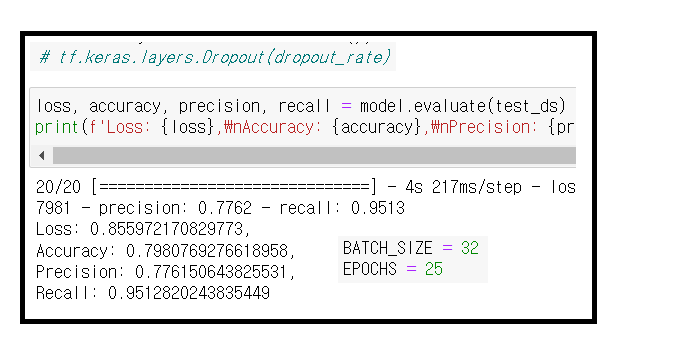

- 3차 시도 정확도: 77%
- 이번에는 BatchNormalization를 포함하고 Dropout을 제거하여 시도했고 에포크는 기존보다 올렸더니 정확도가 조금 더 올랐다.

# 4차 시도

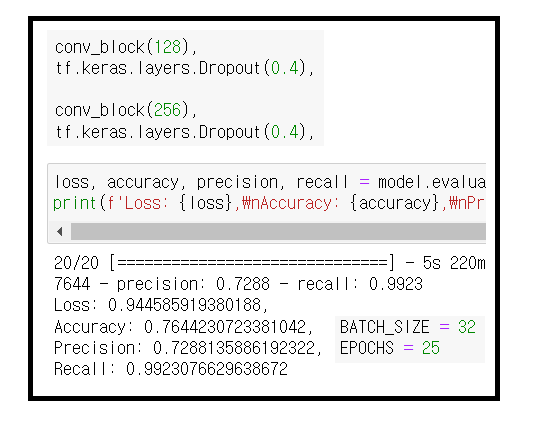

- 4차 시도 정확도: 76%
- 배치사이즈는 32 에포크는 25로 그대로 놓았고, 앞서 BatchNormalization과 Dropout이 모두 사용했을 때의 1차 시도가 정확도가 제일 높았기 때문에 Droput의 비율만 변경(0.3 -> 0.4)했더니 정확도가 76%로가 나왔다.

# 5차 시도

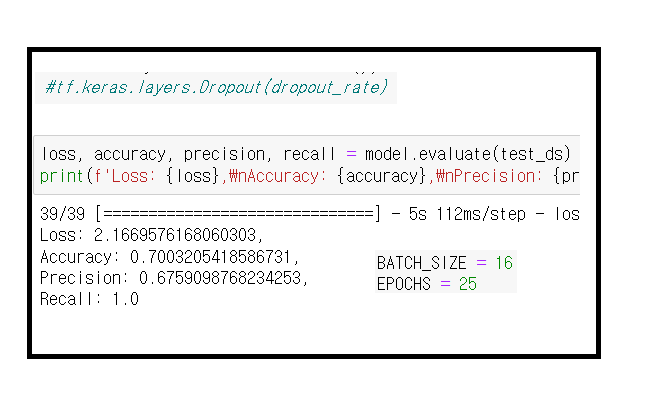

- 5차 시도 정확도: 70%
- Dropout이 정확도에 크게 영향을 주지 않은 것 같다 생각하고, BatchNormalization를 다시 한 번 제거해보았다. 배치 사이즈는 32에서 16으로 낮춰보았으나 오히려 정확도가 기존보다 낮춰졌고, 배치 사이즈를 줄여서는 정확도를 높이는 것에 도움이 되지 않다고 판단하게 됐다.

# 6차 시도

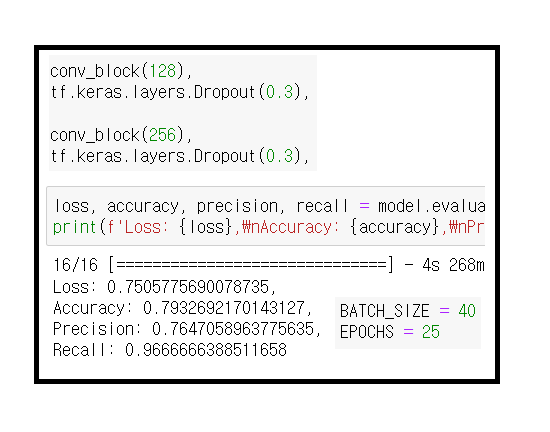

- 6차 시도 정확도: 79%
- 배치사이즈를 크게 한다면 정확도가 더 높아질 것 같다는 판단이 들어, 배치 사이즈를 40으로 올리고 DropoutBatchNormalization와 Dropout를 모두 사용했다. 확실히 효과가 있다고 판단은 했으나, 출력했던 이미지 배치에서 이미지들의 라벨들이 겹치는 문제점이 생겨 보기불편했다.

# 7차 시도

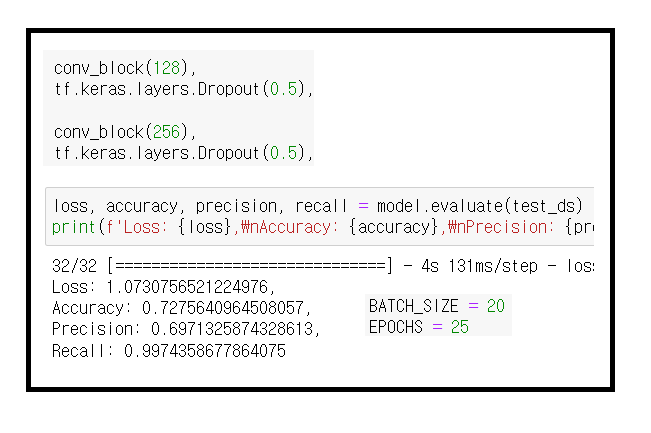

- 7차 시도 정확도: 72%
- 배치 사이즈를 낮추고, 드롭아웃 비율을 조정(0.3->0.5)하니 다시 정확도가 낮아졌다.

# 8차 시도

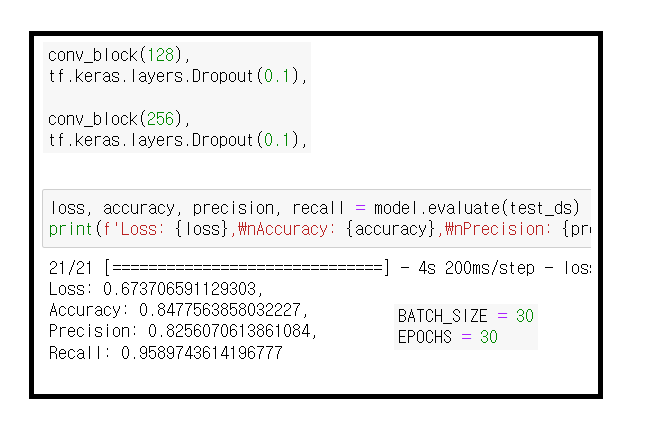

- 8차 시도 정확도: 84%
- 기존에 유지하던 25에포크보다는 1차 시도와 같게 30 에포크로 했고, 배치 사이즈는 30으로 맞춰 진행했다. BatchNormalization과 Dropout모두 사용했고, 드롭아웃의 비율은 0.5일때 좋지 않은 결과를 보여, 과감하게 0.1로 낮추었더니 84.7%로 85퍼에 가까운 결과를 보여 만족스러운 정확도를 보였다. 

---

### 3.2 참조

- BatchNormalization과 Dropout: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=laonple&logNo=221212462034
- Dropout 비율: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ko

---

### 3.3 회고


이번 노드에서 루브릭 평가 기준이 정확도 85%를 도달하는 조건이 있었기에 정확도를 맞추는 것에만 신경을 많이썼던 것 같다. 학습시간도 비교적 시간이 오래 걸렸기 때문에 다른 시도를 크게 해보지 못했다. 처음에 적절한 에포크와 배치사이즈를 찾았다면, BatchNormalization와 Dropout을 사용했을 때 이점에 대해 잘 배울 수 있었을텐데 그렇지도 못했던 것 같아 아쉬움이 크게 남는다. 다음 노드 때에 학습 초기상태에서 점차 모델 형성을 변경해나가는 것이 배움에 크게 도움될 것 같다는 생각이다.

추후 더 생각해봐야 할 것 
- Convolution filter, 채널 개수, activation, 모델 구조 변경에 따른 결과
- BatchNormalization과 Dropout에 대한 개념
- class_weight 설정 생략했을 경우
- recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 방법